In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import  MaxPooling2D, Conv2D, Dropout, Conv2DTranspose, Input, concatenate, Dense, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, accuracy_score, classification_report
import cv2
from skimage import io, color, exposure
from tensorflow.keras.utils import load_img, img_to_array
from google.colab.patches import cv2_imshow


DATASET

In [87]:
# Define the custom preprocessing function
def custom_preprocess(img):
    img = img_to_array(img)
    # Crop the image
    cropped_img = img[30:253, 30:253]
    img = img / 255.0
    return img

train_validation_datagen = ImageDataGenerator(validation_split = 0.20,
                                  rescale=1/255,
                                  preprocessing_function=custom_preprocess,
                                  samplewise_center=True,
                                  samplewise_std_normalization= True)

Test_datagen = ImageDataGenerator(rescale=1/255,
                                  preprocessing_function=custom_preprocess,
                                  samplewise_center=True,
                                  samplewise_std_normalization= True)


In [52]:
Train_path ='/content/drive/MyDrive/COVX_tn/Dataset/Train_Validation'
Train_data= train_validation_datagen.flow_from_directory(Train_path, batch_size=20, class_mode='categorical' ,
                                                         target_size= (224,224),shuffle=False ,subset='training')
Validation_data = train_validation_datagen.flow_from_directory(Train_path, batch_size=20, class_mode='categorical',
                                                               target_size= (224,224), shuffle=False,subset='validation')

Test_path ='/content/drive/MyDrive/COVX_tn/Dataset/Test'
Test_data= Test_datagen.flow_from_directory(Test_path, class_mode='categorical',
                                            batch_size=20, target_size= (224,224), shuffle=False)

Found 2309 images belonging to 3 classes.
Found 575 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


Model 1 : Non pre-trained architecture

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, 3,padding="same", activation="relu", input_shape=(224,224,3)))
model1.add(Conv2D(32, 3,padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D())
model1.add(Dropout(0.4))

model1.add(Conv2D(64, 3, padding="same", activation="relu"))
model1.add(Conv2D(64, 3, padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D())
model1.add(Dropout(0.4))

model1.add(Flatten())
model1.add(Dense(512,activation="relu"))
model1.add(Dense(3, activation="softmax"))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

In [54]:
# save the best model
Best_path1 = '/content/drive/MyDrive/COVX_tn/models/model1'
callbacks1 = ModelCheckpoint(filepath=Best_path1, verbose=2 , save_best_only= True)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
history1 = model1.fit (Train_data, batch_size=32, epochs=15 ,validation_data= Validation_data,
                       callbacks=callbacks1, verbose =2)

In [ ]:
# val_loss and loss curves model1
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc=None)
plt.show()

In [ ]:
# val_accuracy and accuracy curves model1
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

CONFUSION MATRIX (Model 1)

In [ ]:
Y_pred = model1.predict(Test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cf_matrix = confusion_matrix(Test_data.classes, y_pred)
print(cf_matrix)
ConfusionMatrixDisplay.from_predictions(Test_data.classes, y_pred, cmap='Blues', display_labels=Test_data.class_indices)
plt.title('CovX-TN classifier - confusion matrix\n\n')
plt.ylabel('REAL')
plt.xlabel('PREDICTED')
plt.show()

In [ ]:
print(accuracy_score(Test_data.classes, y_pred))
print(classification_report(Test_data.classes, y_pred))

Model 2 : VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
Vgg16 = VGG16 (include_top=False, weights="imagenet", input_tensor=None, input_shape=(224,224,3))

for layer in Vgg16.layers:
	layer.trainable = False  #keeps Imagneet weights
model2 = Sequential()
model2.add(Flatten(input_shape=Vgg16.output_shape[1:]))
model2.add(Dense(units=120,activation="relu"))
model2.add(Dropout(0.4))
model2.add(Dense(units=64,activation="relu"))
model2.add(Dense(units=3, activation="softmax"))

model2 = Model(inputs = Vgg16.input, outputs = model2(Vgg16.output))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='categorical_crossentropy',
                metrics=['accuracy'])
model2.summary()

In [61]:
#Save the best model
Best_path2 = '/content/drive/MyDrive/COVX_tn/models/model2'
callbacks2 = ModelCheckpoint(filepath=Best_path2, verbose=2 , save_best_only= True)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
history2 = model2.fit (Train_data, batch_size=32, epochs=50 ,validation_data= Validation_data,
                       callbacks=callbacks2, verbose =2)

In [ ]:
#val_loss and loss curves model2
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc=None)
plt.show()

In [ ]:
#val_accuracy and accuracy curves model2
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Confusion matrix model2
Y_pred2 = model2.predict(Test_data)
y_pred2 = np.argmax(Y_pred2, axis=1)
print('Confusion Matrix')
cf_matrix = confusion_matrix(Test_data.classes, y_pred2)
print(cf_matrix)
ConfusionMatrixDisplay.from_predictions(Test_data.classes, y_pred2, cmap='Blues', display_labels=Test_data.class_indices)
plt.title('CovX-TN classifier - confusion matrix\n\n')
plt.ylabel('REAL')
plt.xlabel('PREDICTED')
plt.show()

In [ ]:
print(accuracy_score(Test_data.classes, y_pred2))
print(classification_report(Test_data.classes, y_pred2))



---



Model 3 : DensNet 169



In [ ]:
from keras.applications.densenet import DenseNet169
DN169 = DenseNet169 (include_top=False, weights="imagenet", input_tensor=None, input_shape=(224,224,3))

for layer in DN169.layers:
	layer.trainable = False

model3 = Sequential()
model3.add(Flatten(input_shape=DN169.output_shape[1:]))
model3.add(Dense(units=120,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(units=64,activation="relu"))
model3.add(Dense(units=3, activation="softmax"))

model3 = Model(inputs = DN169.input, outputs = model3(DN169.output))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

In [68]:
#Save the best model
Best_path3 = '/content/drive/MyDrive/COVX_tn/models/model3'
callbacks3 = ModelCheckpoint(filepath=Best_path3, verbose=2 , save_best_only= True)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
history3 = model3.fit (Train_data, batch_size=32, epochs=50 ,validation_data= Validation_data,
                       callbacks=callbacks3, verbose =2)

In [ ]:
# val_loss and loss curves model3
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc=None)
plt.show()

In [ ]:
#Val_accuracy and accuracy model3
import matplotlib.pyplot as plt
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Confusion matrix model3
Y_pred3 = model3.predict(Test_data)
y_pred3 = np.argmax(Y_pred3, axis=1)
print('Confusion Matrix')
cf_matrix = confusion_matrix(Test_data.classes, y_pred3)
print(cf_matrix)
ConfusionMatrixDisplay.from_predictions(Test_data.classes, y_pred3, cmap='Blues', display_labels=Test_data.class_indices)
plt.title('CovX-TN classifier - confusion matrix\n\n')
plt.ylabel('REAL')
plt.xlabel('PREDICTED')
plt.show()

Ensemble Learning

In [ ]:
#Loading best models

best_model1 = '/content/drive/MyDrive/COVX_tn/models/model1'
model1 = keras.models.load_model(best_model1)
predict_test = model1.predict(Validation_data)

best_model2 = '/content/drive/MyDrive/COVX_tn/models/model2'
model2 = keras.models.load_model(best_model2)
predict_test2 = model2.predict(Validation_data)

best_model3 = '/content/drive/MyDrive/COVX_tn/models/model3'
model3 = keras.models.load_model(best_model3)
predict_test3 = model3.predict(Validation_data)

# models accuracy_scores
print(accuracy_score(Test_data.classes, y_pred))
print(accuracy_score(Test_data.classes, y_pred2))
print(accuracy_score(Test_data.classes, y_pred3))

In [ ]:
#Final predictions aggregation
ensemble_predict_test = predict_test + predict_test2 + predict_test3
y_pred_ensemble = np.argmax(ensemble_predict_test, axis=1)
print(accuracy_score(Validation_data.classes, y_pred_ensemble))

In [ ]:
#Stacking

#Predictions_train_data
predict_tr1 = model1.predict(Train_data)
predict_tr2 = model2.predict(Train_data)
predict_tr3 = model3.predict(Train_data)

#Stacking predictions of train and test data
train_stack = np.hstack((predict_tr1, predict_tr2, predict_tr3))
test_stack = np.hstack((predict_test, predict_test2, predict_test3))

# Define meta-learner model
meta_model = Sequential([
    Flatten(input_shape=(train_stack.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')])

# Compile meta-learner model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
meta_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

y_train = Train_data.classes
y_test = Validation_data.classes

# One-hot encode labels
num_classes = 3
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [ ]:
# Train meta-learner
meta_model.fit(train_stack, y_train, epochs=200, batch_size=64, validation_data=(test_stack, y_test))

In [85]:
# Evaluate meta-learner
meta_predictions = meta_model.predict(test_stack)
meta_accuracy = np.mean(np.argmax(meta_predictions, axis=1) == np.argmax(y_test, axis=1))
print(f'Stacking model accuracy: {meta_accuracy}')

18/18 [==============================] - 0s 2ms/step
Stacking model accuracy: 0.9460869565217391


Grad-CAM

1/1 [==============================] - 0s 35ms/step
The given X-Ray image is of type =  COVID
1/1 [==============================] - 0s 36ms/step
The chances of image being Covid is : 67.92417168617249 percent
1/1 [==============================] - 0s 33ms/step
The chances of image being Normal is: 0.15166644006967545 percent
1/1 [==============================] - 0s 52ms/step
The chances of image being Pneumonia is: 31.924161314964294 percent


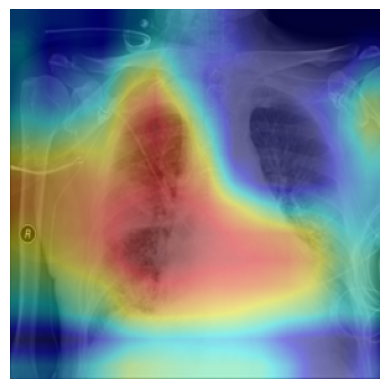

In [106]:
# Preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = img [30:253, 30:253]
    img = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img, axis=0)
    img_array /= 255.0
    return img_array

# Generate Grad-CAM heatmap
def generate_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Overlay heatmap on image
def overlay_heatmap(heatmap, img_path, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img

# Path to the image
img_path = '/content/drive/MyDrive/COVX_tn/Dataset/Test/Pneumonia/Lung_Opacity-4419.png'
img_array = preprocess_image(img_path)

# Generate Grad-CAM
last_conv_layer_name = 'block5_conv3'  # model 2 (VGG16)
#last_conv_layer_name = 'conv2d_3' #Model 1(Non pre-trained model)
#last_conv_layer_name = 'conv5_block32_concat' #Model3 (Densenet169)
heatmap = generate_gradcam(model2, img_array, last_conv_layer_name)

# Overlay heatmap on the original image
superimposed_img = overlay_heatmap(heatmap, img_path)

#prediction
Labels = ['COVID', 'Normal','Pneumonia']
Result = Labels[np.argmax(model2.predict(img_array))]
print("The given X-Ray image is of type = " , Result)
print("The chances of image being Covid is :" , model2.predict(img_array)[0][0]*100, "percent")
print("The chances of image being Normal is:", model2.predict(img_array)[0][1]*100, "percent")
print("The chances of image being Pneumonia is:", model2.predict(img_array)[0][2]*100, "percent")

# Display the image
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()